# Plots for Transfer model. 
#### 1. Imports, Datasets, and Models.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy      as np

from umap import UMAP

import tensorflow as tf

from pretrain_model import AMPPretrainLearner
from transfer_model import AMPTransferLearner, get_aa_embeding_dists
# Load the model.
pretrain_model = AMPPretrainLearner()
pretrain_model.load_weights('./c_transfer_learning/models_pretrain/amp_pretrain_learner_weights.h5')

pretrain_embedding = pretrain_model.l_we.embedding.embeddings.numpy()
aa_dists = get_aa_embeding_dists(pretrain_embedding)
    
transfer_model = AMPTransferLearner(pretrain_model, aa_dists)
transfer_model.load_weights('./c_transfer_learning/models_transfer/amp_transfer_learner_weights.h5')

# Prepare the transfer datasets (with nterm). 
train_seq   = np.load('./b_preprocessing/transfer/train_seq.npy'  )
train_label = np.load('./b_preprocessing/transfer/train_label.npy')[:, np.newaxis]
train_nterm = np.load('./b_preprocessing/transfer/train_nterm.npy')[:, np.newaxis]
valid_seq   = np.load('./b_preprocessing/transfer/valid_seq.npy'  )
valid_label = np.load('./b_preprocessing/transfer/valid_label.npy')[:, np.newaxis]
valid_nterm = np.load('./b_preprocessing/transfer/valid_nterm.npy')[:, np.newaxis]    

t_seq   = np.concatenate((train_seq,   valid_seq),   axis=0)
t_label = np.concatenate((train_label, valid_label), axis=0)
t_nterm = np.concatenate((train_nterm, valid_nterm), axis=0)

# The pretrain data arrays
ptrain_seq   = np.load('./b_preprocessing/pretrain/train_seq.npy'  )
ptrain_label = np.load('./b_preprocessing/pretrain/train_label.npy')[:, np.newaxis]
ptrain_nterm = np.zeros(ptrain_label.shape)
pvalid_seq   = np.load('./b_preprocessing/pretrain/valid_seq.npy'  )
pvalid_label = np.load('./b_preprocessing/pretrain/valid_label.npy')[:, np.newaxis]
pvalid_nterm = np.zeros(pvalid_label.shape)

p_seq   = np.concatenate((ptrain_seq,   pvalid_seq),   axis=0)
p_label = np.concatenate((ptrain_label, pvalid_label), axis=0)
p_nterm = np.concatenate((ptrain_nterm, pvalid_nterm), axis=0)


t_seq.shape, t_label.shape, t_nterm.shape, p_seq.shape, p_label.shape, p_nterm.shape

2023-03-19 01:02:50.728515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 01:02:50.985866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 01:02:50.985896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-19 01:02:51.030425: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-19 01:02:51.971693: W tensorflow/stream_executor/platform/de

((310, 15), (310, 1), (310, 1), (64084, 15), (64084, 1), (64084, 1))

#### 2. Visualizations of the Latent embedding of the Transfer model
**This is the latent space right before the output.**

*a. load data and do dimred*

In [2]:
platent = transfer_model((p_seq, p_nterm), training=False)
platent = transfer_model.latent_vec.numpy().flatten().reshape((-1, 16)) # 16 is from the source code.

tlatent = transfer_model((t_seq, t_nterm), training=False)
tlatent = transfer_model.latent_vec.numpy().flatten().reshape((-1, 16)) # 16 is from the source code.

all_latent = np.concatenate((platent, tlatent), axis=0)

umap = UMAP(n_neighbors=100, random_state=0)
umap.fit(all_latent)

platent_dimred = umap.transform(platent)
tlatent_dimred = umap.transform(tlatent)

platent_dimred.shape, tlatent.shape

/home/songzl/software/miniconda3/envs/dl_amp/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


((64084, 2), (310, 16))

*b.make plot of all pretrain latent points.*

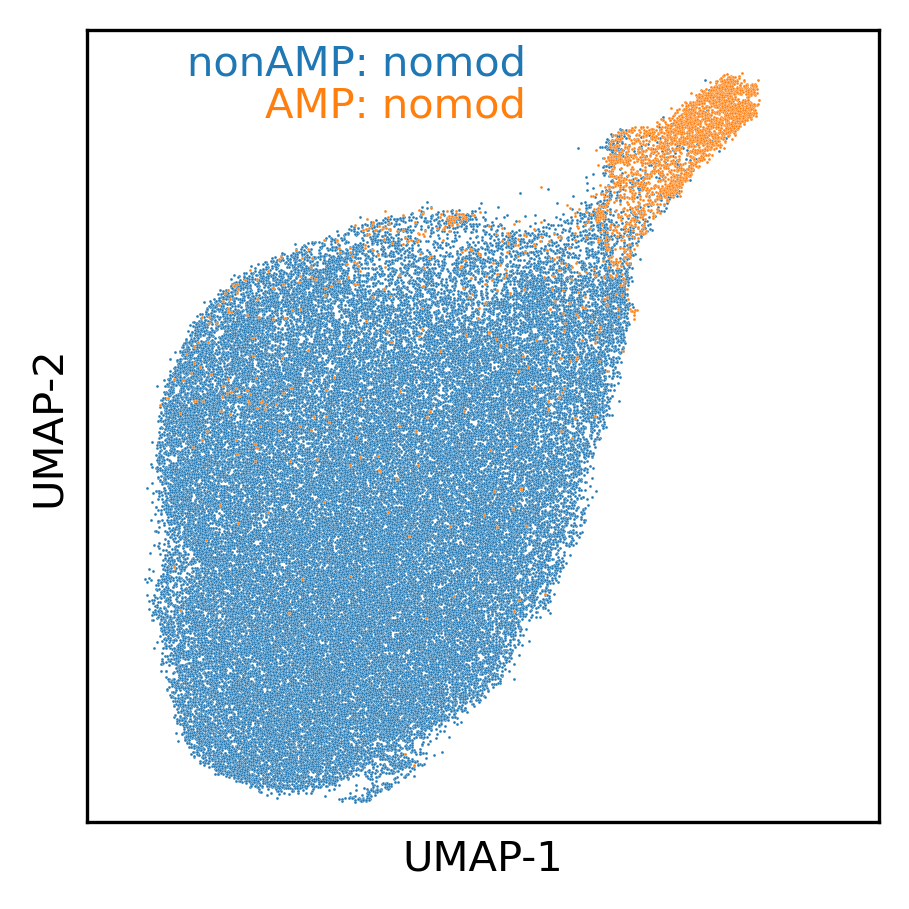

In [3]:
neg_platent_dimred = platent_dimred[np.where(p_label.flatten()==0)]
pos_platent_dimred = platent_dimred[np.where(p_label.flatten()==1)]

fig, ax = plt.subplots(figsize=(3.5, 3.5), nrows=1, ncols=1, dpi=300, sharex=True, sharey=True)
sns.scatterplot(x=neg_platent_dimred[:, 0], y=neg_platent_dimred[:, 1], s=.5)
sns.scatterplot(x=pos_platent_dimred[:, 0], y=pos_platent_dimred[:, 1], s=.5)

ax.text(x=3.75, y=13.75, s='nonAMP: nomod', c=sns.color_palette()[0], ha='right', va='top')
ax.text(x=3.75, y=13.00, s='AMP: nomod',    c=sns.color_palette()[1], ha='right', va='top')

ax.set_xlim(-4, 10)
ax.set_ylim(0, 14)
ax.set_aspect('equal', adjustable='box')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

np.save('./c_transfer_learning/arrays/transfer_nodecor_all_latent_dr.npy',  platent_dimred)
np.save('./c_transfer_learning/arrays/transfer_nodecor_amp_latent_dr.npy',  pos_platent_dimred)
np.save('./c_transfer_learning/arrays/transfer_nodecor_namp_latent_dr.npy', neg_platent_dimred)

plt.savefig('./z_figures/transfer_nodecor_seq_latent_dr.png')
plt.show()

*c.make plot of all transfer latent points.*

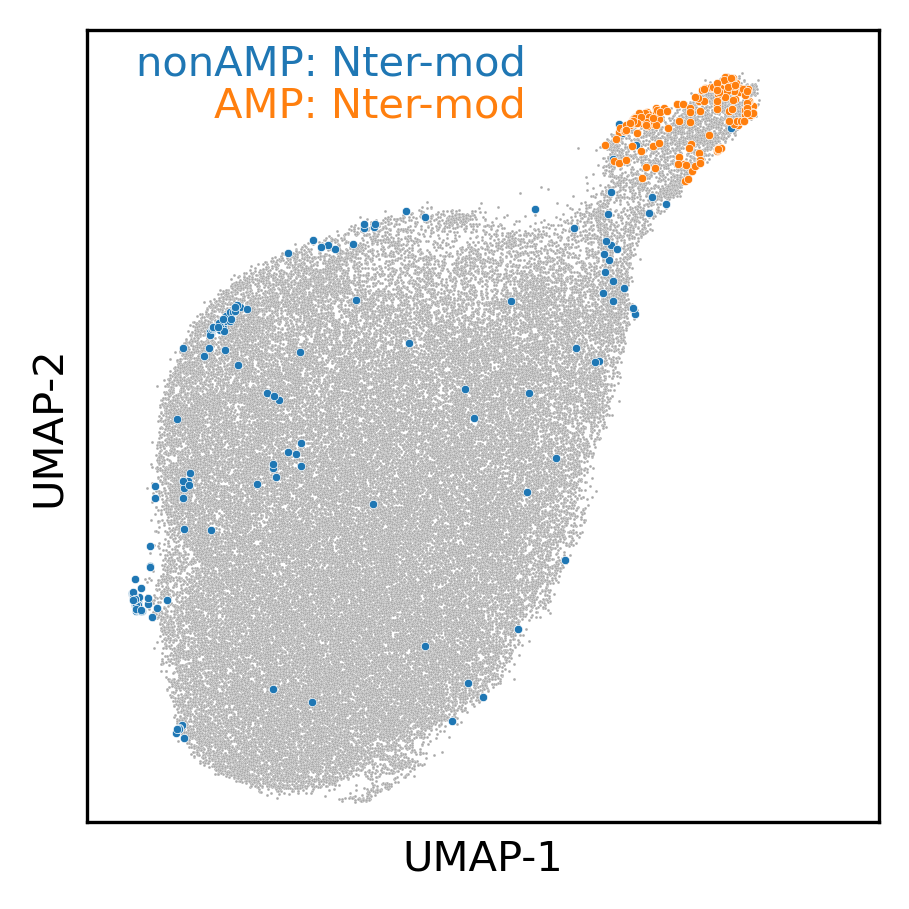

In [4]:
neg_tlatent_dimred = tlatent_dimred[np.where(t_label.flatten()==0)]
pos_tlatent_dimred = tlatent_dimred[np.where(t_label.flatten()==1)]

fig, ax = plt.subplots(figsize=(3.5, 3.5), nrows=1, ncols=1, dpi=300, sharex=True, sharey=True)
sns.scatterplot(x=platent_dimred[:, 0], y=platent_dimred[:, 1], s=.5, c='darkgray')
sns.scatterplot(x=neg_tlatent_dimred[:, 0], y=neg_tlatent_dimred[:, 1], s=4)
sns.scatterplot(x=pos_tlatent_dimred[:, 0], y=pos_tlatent_dimred[:, 1], s=4)

ax.text(x=3.75, y=13.75, s='nonAMP: Nter-mod', c=sns.color_palette()[0], ha='right', va='top')
ax.text(x=3.75, y=13.00, s='AMP: Nter-mod',    c=sns.color_palette()[1], ha='right', va='top')

ax.set_xlim(-4, 10)
ax.set_ylim(0, 14)
ax.set_aspect('equal', adjustable='box')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')

np.save('./c_transfer_learning/arrays/transfer_decor_all_latent_dr.npy',  platent_dimred)
np.save('./c_transfer_learning/arrays/transfer_decor_amp_latent_dr.npy',  pos_platent_dimred)
np.save('./c_transfer_learning/arrays/transfer_decor_namp_latent_dr.npy', neg_platent_dimred)

plt.savefig('./z_figures/transfer_decor_seq_latent_dr.png')
plt.show()